### Spatial mapping of human lung region snRNA-seq to Visium (for Elo) - with scVI non-amortised inference

In [1]:
import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
#import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps
6. Identify co-occuring cell type combinations using matrix factorisation



## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/regions_with_visium_all/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'
scvi_ref_run_name = f'{results_folder}/non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_ref'
scvi_run_name = f'{results_folder}/non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_ref_wo_lowQ'

annotation_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/Loupe_annotations/'

In [3]:
adata_vis = sc.read_h5ad(f'{scvi_run_name}/sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot everything to get rid of warnings later
sc.pl.spatial(adata_vis, 
              color=["EPCAM"], img_key=None,
              vmin=0, library_id='WSA_LngSP9258467',
              gene_symbols='SYMBOL'
             )

In [5]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_snsc_selection_ref", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

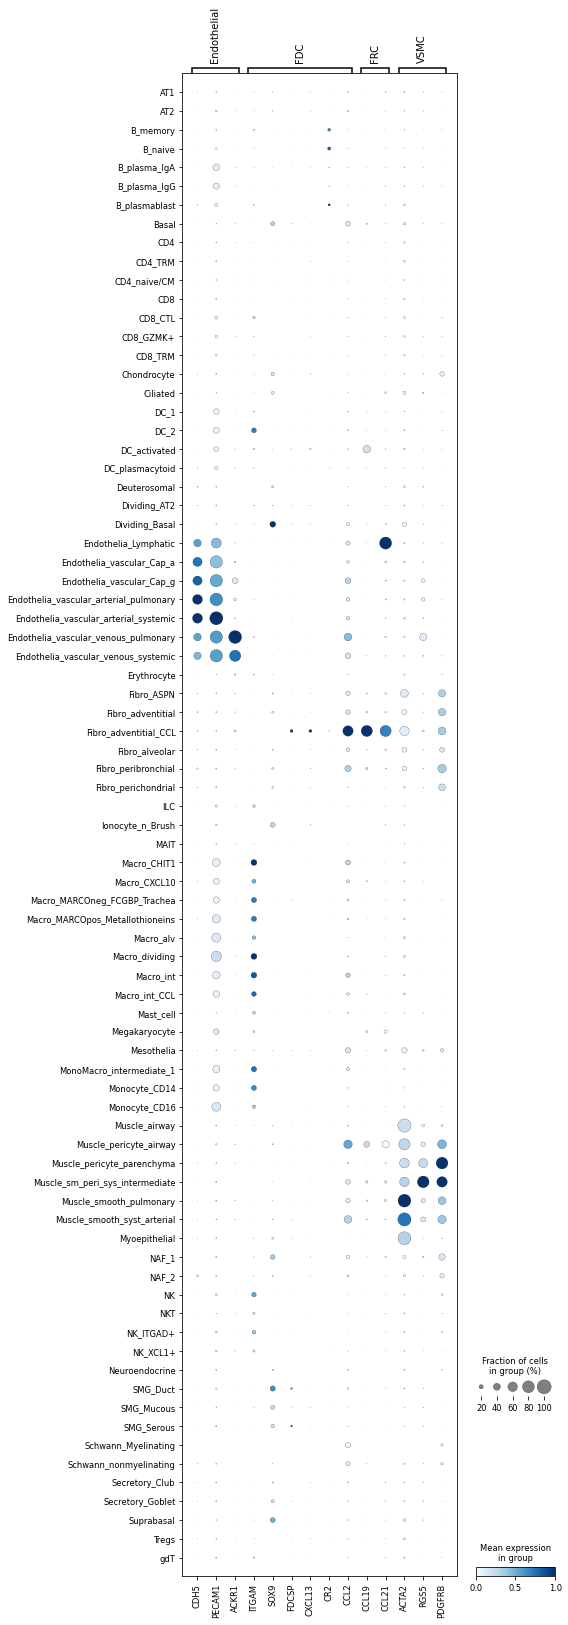

In [7]:
marker_genes_dict = {
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2", "CCL2"],  
'FRC': ["CCL19", "CCL21"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

with mpl.rc_context({'figure.figsize': [5.2, 3],
                     'axes.facecolor': 'white'}):
    ax = sc.pl.dotplot(adata_snrna_raw, marker_genes_dict, groupby='Celltypes_int_F', 
                       dendrogram=False, standard_scale='var',
                       log=False, cmap="Blues",
                       gene_symbols='SYMBOL',
                       #save='dotplot_Tcells.pdf'
                      )

## Spatial plots per cell type

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


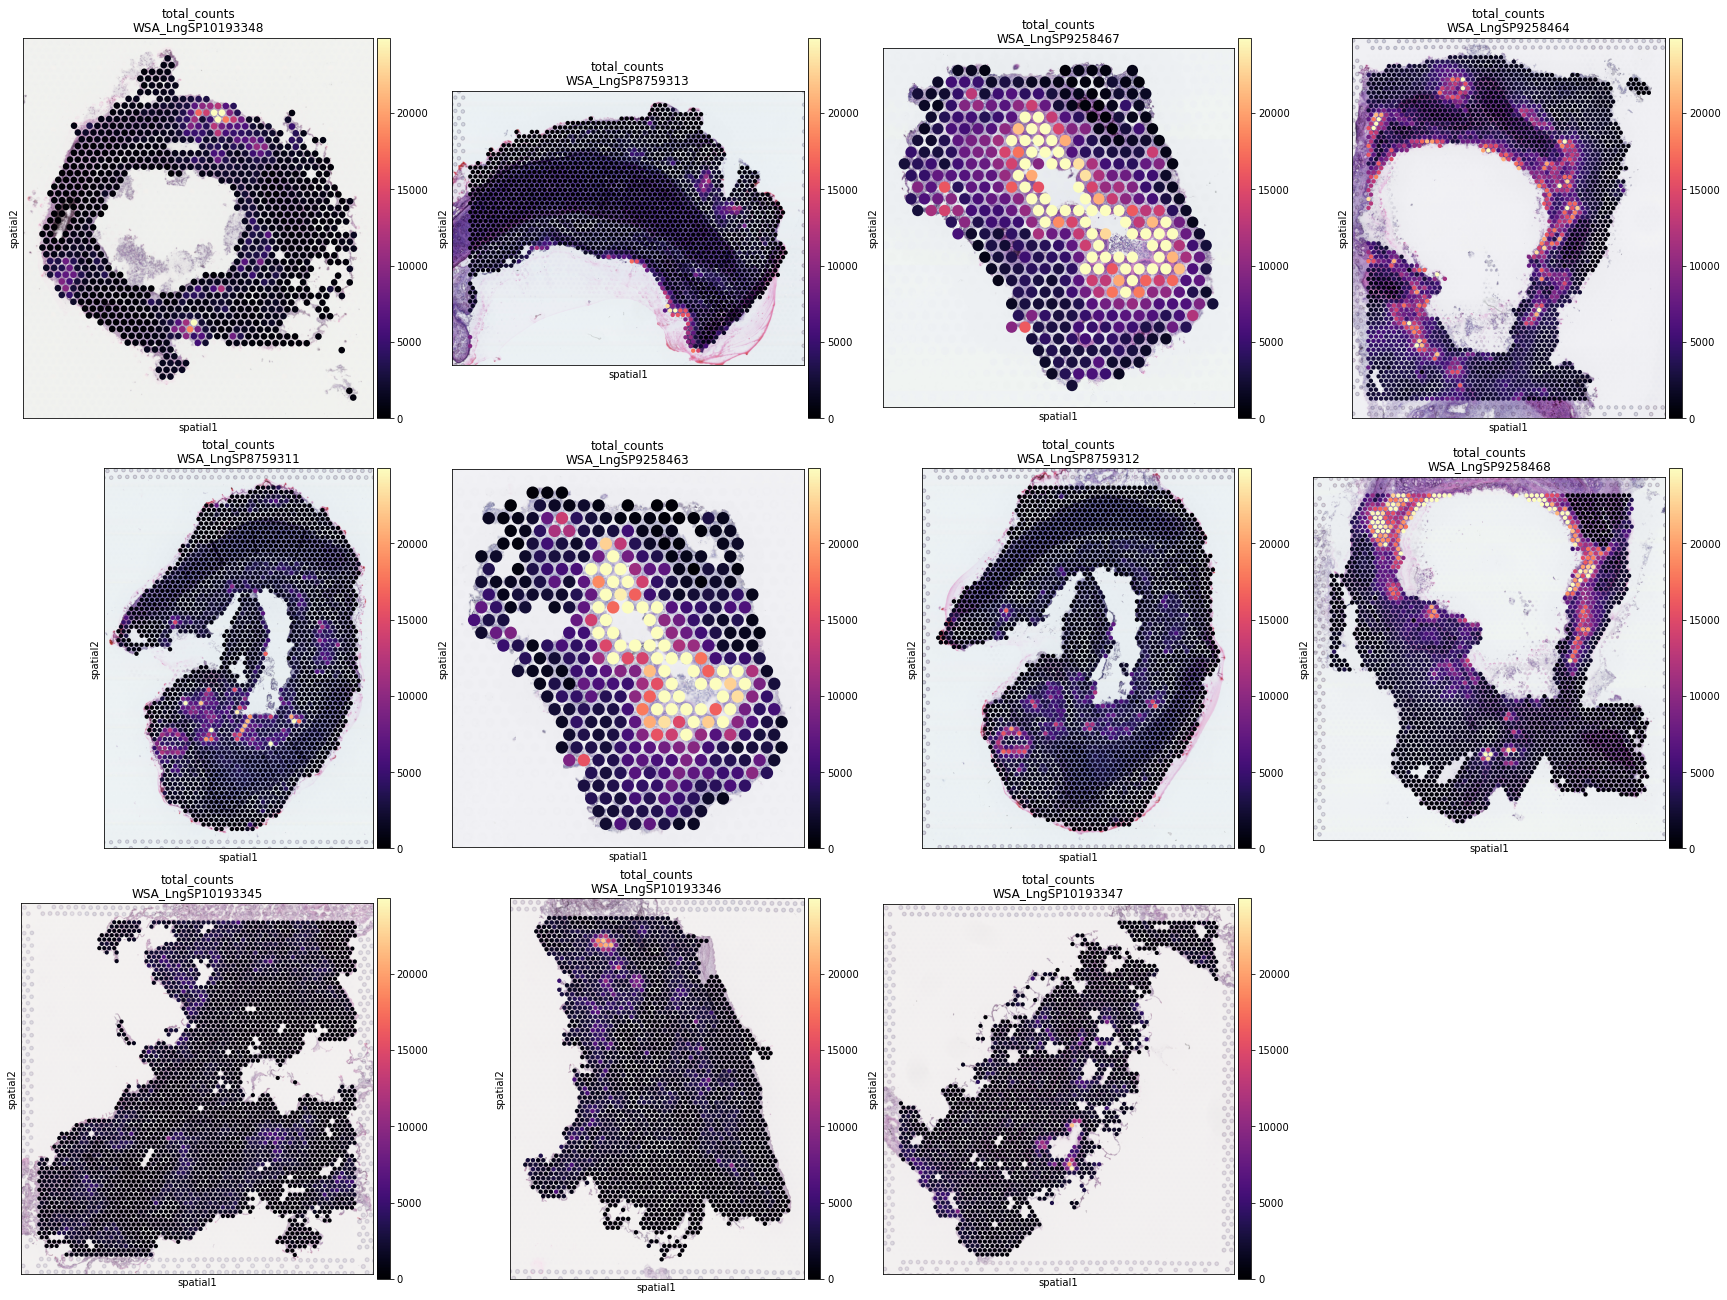

In [8]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-0, crop_max[0]+0]
    crop_y = [crop_min[1]-0, crop_max[1]+0]

    return crop_x, crop_y
    

def plot_spatial_per_cell_type(adata, 
                               cell_type='total_counts',
                               samples=[
       'WSA_LngSP10193348', 'WSA_LngSP8759311', 'WSA_LngSP10193345',
                                    
       'WSA_LngSP8759313', 'WSA_LngSP9258463', 'WSA_LngSP10193346',
                                   
       'WSA_LngSP9258467', 'WSA_LngSP8759312', 'WSA_LngSP10193347',
                                   
       'WSA_LngSP9258464', 'WSA_LngSP9258468',
                               ],
                              ncol=4, prefix='', figsize=(24, 18),
                              vmax_quantile=0.992):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{prefix}{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, vmax_quantile)
    adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type='total_counts');

### Multi-colour spatial plot

Trying to set attribute `.uns` of view, copying.


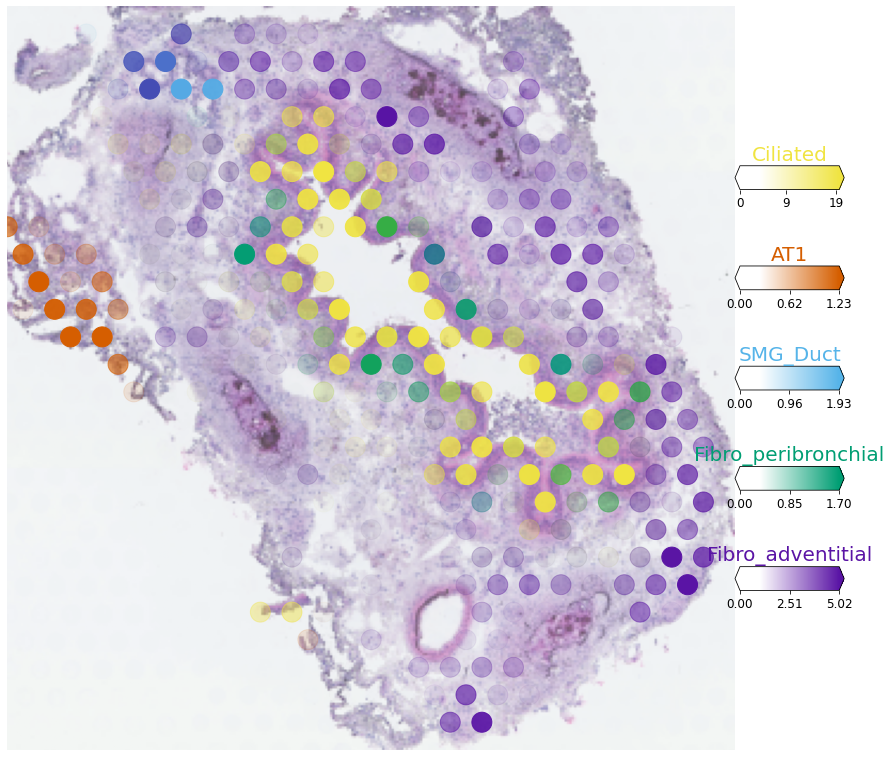

In [11]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 5-6 clusters (the last colour is grey)
sel_clust = ['Ciliated', 'AT1', 'SMG_Duct', 'Fibro_peribronchial', 'Fibro_adventitial']
sel_clust_col = ['' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'WSA_LngSP9258467')
crop_x, crop_y = get_crop_coord(slide)

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                  show_img=True, img_alpha=0.8,
                  max_color_quantile=0.995,
                  crop_x=crop_x, crop_y=crop_y,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=20, colorbar_position='right')

In [12]:
adata_vis.uns['mod']['factor_names']#.to_csv('./factor_names')

array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
       'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4', 'CD4_TRM',
       'CD4_naive/CM', 'CD8', 'CD8_CTL', 'CD8_GZMK+', 'CD8_TRM',
       'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2', 'DC_activated',
       'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
       'Dividing_Basal', 'Endothelia_Lymphatic',
       'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
       'Endothelia_vascular_arterial_pulmonary',
       'Endothelia_vascular_arterial_systemic',
       'Endothelia_vascular_venous_pulmonary',
       'Endothelia_vascular_venous_systemic', 'Erythrocyte', 'Fibro_ASPN',
       'Fibro_adventitial', 'Fibro_adventitial_CCL', 'Fibro_alveolar',
       'Fibro_peribronchial', 'Fibro_perichondrial', 'ILC',
       'Ionocyte_n_Brush', 'MAIT', 'Macro_CHIT1', 'Macro_CXCL10',
       'Macro_MARCOneg_FCGBP_Trachea', 'Macro_MARCOpos_Metallothioneins',
       'Macro_alv', 'Macro_dividing', 'Macro_int', 'Macro_int_CCL',
       'Mast

### Dotplot by histology-based annotation

In [14]:
# read histology-based annotations of iBALT:
annot_ = pd.read_csv(f'{annotation_folder}WSA_LngSP10193348/iBALT.csv', index_col='Barcode')
annot_.index = [f'WSA_LngSP10193348_{j}' for j in annot_.index]
annot_ = annot_.loc[annot_['iBALT'] == 1.0, :]
adata_vis.obs.loc[adata_vis.obs_names.isin(annot_.index), 'iBALT'] = '1.0'
adata_vis.obs['iBALT'].value_counts(dropna=False)

NaN    20759
1.0       11
Name: iBALT, dtype: int64

In [14]:
# read histology-based annotations of Glands:
annot_ = pd.read_csv(f'{annotation_folder}WSA_LngSP10193348/Glands.csv', index_col='Barcode')
annot_.index = [f'WSA_LngSP10193348_{j}' for j in annot_.index]
annot_ = annot_.loc[annot_['Glands'] == 1.0, :]
adata_vis.obs.loc[adata_vis.obs_names.isin(annot_.index), 'Glands'] = '1.0'
adata_vis.obs['Glands'].value_counts(dropna=False)

NaN    20759
1.0       11
Name: iBALT, dtype: int64

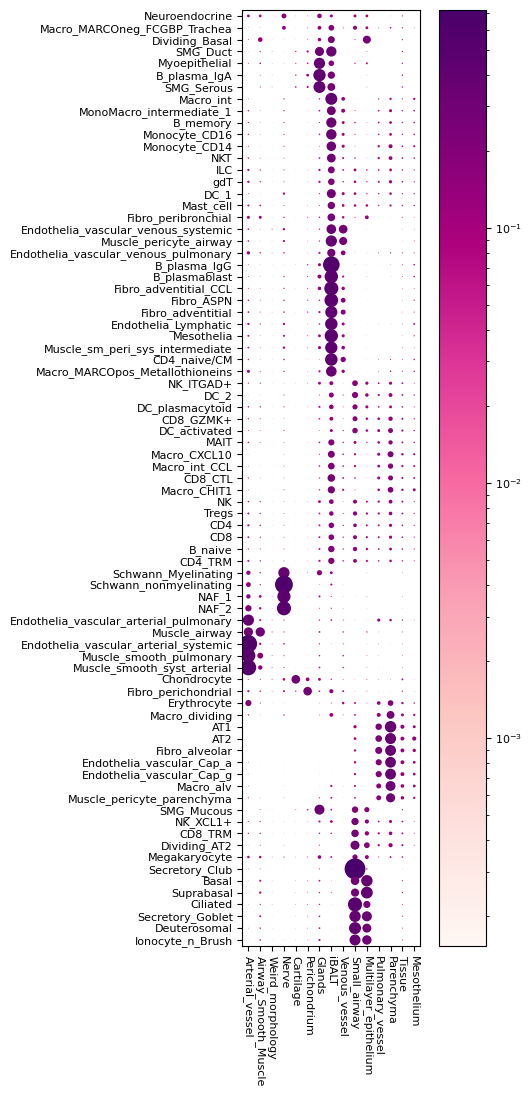

In [15]:
fig_dir = f'{scvi_run_name}/plots/'

annot_ = ['Tissue', 'Perichondrium', 'Cartilage', 'Glands',
       'Multilayer_epithelium', 'Airway_Smooth_Muscle', 'Weird_morphology',
       'Nerve', 'Venous_vessel', 'Arterial_vessel', 'Parenchyma',
       'Mesothelium', 'Pulmonary_vessel', 'Small_airway', 'iBALT']

annot_abundance_df = pd.DataFrame(index=adata_vis.uns['mod']['factor_names'],
                                  columns=annot_)
for a in annot_:
    ind = adata_vis.obs[a] == '1.0'
    annot_abundance_df[a] = adata_vis.obs.loc[ind, adata_vis.uns['mod']['factor_names']].mean(0)
    
annot_abundance_norm = (annot_abundance_df.T / annot_abundance_df.sum(1)).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    clustermap(annot_abundance_norm, figure_size=(5, 11), 
               cmap='RdPu', log=True, fun_type='dotplot',
               cluster_rows=True, cluster_cols=True)
    plt.savefig(f"{fig_dir}histology_annotation_dotplot.pdf",
                    bbox_inches='tight')
    plt.show()

### NMF analysis

In [19]:
from cell2location import run_colocation
adata_vis.uns['mod']['post_sample_q05']['spot_factors'] = adata_vis.uns['mod']['post_sample_q05']['w_sf'].copy()
adata_vis.uns['mod']['fact_names'] = adata_vis.uns['mod']['factor_names'].copy()
res_dict, adata_vis = run_colocation(
                   adata_vis, model_name='CoLocatedGroupsSklearnNMF',
                   verbose=False, return_all=True,

                   train_args={
                    'n_fact': np.arange(14, 28), # IMPORTANT: range of number of factors (10-40 here)
                    'n_iter': 20000, # maximum number of training iterations

                    'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample

                    'mode': 'normal',
                    'n_type': 'restart', 'n_restarts': 5 # number of training restarts
                   },

                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.00001}},

                   posterior_args={},
                   export_args={'path': scvi_run_name+'/CoLocatedComb/',
                                'run_name_suffix': ''})

### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.

Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 

... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categoric

### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as cat

... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.

### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_20770locations_79factors


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical

... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway_old' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage' as categorical
Trying to set attribute `.o

... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cartilage_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Perichondrium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Glands_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Weird_morphology_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel_old' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel_old' as categorical
Trying to

... storing 'Glands' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Multilayer_epithelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Nerve' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Venous_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Airway_Smooth_Muscle' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Arterial_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Parenchyma' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Pulmonary_vessel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mesothelium' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Small_airway' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'iBALT' as categorical
Trying to set attribute `.obs` of view, copyin

... storing 'Perichondrium' as categorical
... storing 'Weird_morphology' as categorical
... storing 'Cartilage' as categorical
... storing 'Glands' as categorical
... storing 'Multilayer_epithelium' as categorical
... storing 'Nerve' as categorical
... storing 'Venous_vessel' as categorical
... storing 'Airway_Smooth_Muscle' as categorical
... storing 'Arterial_vessel' as categorical
... storing 'Parenchyma' as categorical
... storing 'Pulmonary_vessel' as categorical
... storing 'Mesothelium' as categorical
... storing 'Small_airway' as categorical
... storing 'iBALT' as categorical
... storing 'Cartilage_old' as categorical
... storing 'Perichondrium_old' as categorical
... storing 'Glands_old' as categorical
... storing 'Multilayer_epithelium_old' as categorical
... storing 'Airway_Smooth_Muscle_old' as categorical
... storing 'Weird_morphology_old' as categorical
... storing 'Nerve_old' as categorical
... storing 'Venous_vessel_old' as categorical
... storing 'Arterial_vessel_old'

Modules and their versions used for this analysis

In [20]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.10
scanpy 1.7.2
scanpy._metadata 1.7.2
packaging 20.9
packaging.__about__ 20.9
pkg_resources._vendor.six 1.10.0
pkg_resources.extern.six 1.10.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.